In [1]:
import os
from typing import Dict, List, Optional, Any, Literal

# Tavily API
from tavily import TavilyClient

# Langchain
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_classic.vectorstores import Chroma
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# LangChain Anthropic
from langchain_anthropic import ChatAnthropic

# Langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph

# Evaluation 
import mlflow

# Anthropic
from anthropic import Anthropic

# Environment Variables
from dotenv import load_dotenv
from IPython.display import Image, display

In [2]:
load_dotenv("config.env")

True

In [3]:
base_llm = ChatOpenAI(
    model="gpt-5.1",
    temperature=0.0,
    verbosity="low",
    reasoning_effort="medium",
    #logprobs=True,
    #top_logprobs=3,
)

In [4]:
small_llm = ChatOpenAI(
    model = "gpt-5-nano",
    temperature = 0.0,
)

In [5]:
quiz_grader = ChatAnthropic(
    model_name="claude-haiku-3.5",
    temperature=0.1,
    )

## Create our tool node and LLM with Tools

In [6]:
tavily_client = TavilyClient()

In [7]:
# Lets define our tavily search tool node

@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query.
    """
    response = tavily_client.search(question)
    print("Im conducting a very important search currently...")
    return response

type(web_search)

langchain_core.tools.structured.StructuredTool

In [8]:
tools = [web_search]

In [9]:
llm_with_tools = base_llm.bind_tools(tools)

## Create our State Schema

In [10]:
class State(MessagesState):
    topic: Optional[str] # Entry node should exit with phase 'ask_topic'. For now we can invoke the graph with the topic
                         # What we can do now to carry over into the next phase is have the entrypoint introduce itself.
    summary: Optional[str]
    quiz_question: Optional[str]
    quiz_options: Optional[List[str]]
    quiz_correct_option: Optional[str]
    patient_answer: Optional[str]
    evaluation: Optional[Dict[str, Any]]
    phase: Optional[
        Literal[
            "ask_topic",
            "searching",
            "show_summary",
            "waiting_ready",
            "quiz_generated",
            "waiting_answer",
            "evaluated",
            "waiting_restart"
        ]
    ]
    repeat_mode: bool
    #Dont need a messages variable because the MessagesState autoimatically includes a messages field

## Create an entrypoint node. 

This node should also be the introduction of the system to the user. 

This node will have an interrupt after to collect the topic the user wants to learn about. 

In [11]:
# lets create our entrypoint into our langgraph workflow.

def entrypoint(state: State)->State:
    
    topic = state["topic"]

    print("Hi Im the Healthbot Assistant, here to help you understand your diagnoses, your condition,\n" \
          "your treatment options, and your post-treatment care instructions. I can answer any health related\n" \
          "questions you have, and I will quiz you to ensure I achieve my goal to aid you in understanding\n" \
          "how to take proper care of yourself in your post-treatment process..")
    
    sys_message = SystemMessage(
        content=(
            "You are the Healthbot Assistant, here to help patients understand their diagnoses, conditions," \
            "treatment options, and provide them post-treatment care instructions. You should only answer health related " \
            "questions from the patient."
        )
    )
    ai_message = AIMessage(
        content=(
            "What health topic or medical condition do you want to learn about?"
        )
    )
    human_message = HumanMessage(topic)

    messages = [sys_message, ai_message, human_message]
   
    return {"messages": messages}

# Need an interrupt after this node to be able to store my topic. This interrupt will be an input for the user to be able to input their desired topic they want to learn about.

## Create our Agent nodes

 - info_agent: uses a higher tier model to gather relevant data into a larger report based on the patients interest
 - summary_agent: uses a smaller model with a subset of the state["messages"] list to process less tokens and only summarize the report generated by the large model. this should somewhat limit token usage and since summarization is a simpler task, we do not need to pass the same large report through a model that costs more during inference.
 - quiz_agent: uses the same smaller model to generate our quiz, again this is a simpler task where we can save on cost.
 - 

In [12]:
# Lets create our info gathering agent node that is bound with tools

def info_agent(state: State):
    # should topic be a config???? review section 3.9
    #state["topic"] = input("What health topic or medical condition do you want to learn about?\n")

    #adding a check
    print("\nProcessing if we need search capability.")
    messages = state["messages"]
    #topic = state["topic"]
    #messages = messages + [topic]
    ai_message = llm_with_tools.invoke(messages)

    return {"messages": messages + [ai_message], "phase": "searching",}

In [13]:
# Create our summarizer. This node is just a base llm
def summary_agent(state: State):
    #adding check
    print("\n--- Sumarizing... ---")
    messages = state["messages"]
    last_message = state["messages"][-1]
    sys_message = SystemMessage(
            content = (
                "Please summarize this into about 3-4 paragraphs. Be concise and provide the most important information to the patient." \
                "Do not exceed 200 words. Please make each paragraph a compact block of text with about 20 words per line and a \n\n in between each paragraph."
            )
        )
    quick_message = [sys_message, last_message]
    summary = small_llm.invoke(quick_message)
    state["summary"] = summary
    #for chunk in small_llm.stream("Why do parrots have colorful feathers?"):
    #print(chunk.text, end="|", flush=True)
    messages = messages + [summary] 

    return{"messages": messages + [summary], "summary": summary.content, "repeat_mode": False, "phase": "show_summary"}
    

In [14]:
##################################################################################################################################################
# Going to need a router to our tool node or next node
##################################################################################################################################################
# CHANGE: router will route to entrypoint if theres no tool call
##################################################################################################################################################

def router_1(state: State):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [15]:
def quiz_agent(state: State):
# Is this the only node for my quiz and does the quiz need a pydantic input to be able to make sure the user answers the quiz?
    if not state["repeat_mode"]:
        summary = state["summary"]
        messages = state["messages"]

        quiz_sys_message = SystemMessage(
            content=("Generate a quiz with one multiple choice question from the summary provided below. Provide 4 options 'A', 'B', 'C', and 'D'." \
            "\nThere should only be one correct answer out of the 4 options you provide." \
            "\nThis quiz will be given to a patient where its your job to make sure the patient understands that they are aware of the instructions" \
            "\nin the summary. Make the quiz question medium defficulty. Only generate the quiz question and multiple choice options. Nothing else." \
            f"\nHere is the summary:\n\n {summary}"))
    
        print("\n---Generating the quiz to reinforce the patients understanding.---")
        quiz_question = small_llm.invoke([quiz_sys_message]) 
        state["quiz_question"] = quiz_question
        quiz = state["quiz_question"]

        sys_answer_message = SystemMessage(
            content=("I need to save the correct answer to the quiz that i am testing the patient with. What is the correct answer?" \
            "Only give me the letter 'A', 'B', 'C', or 'D' for the correct answer response." \
            f"The quiz is:\n\n {quiz}"))

        quiz_correct_option = small_llm.invoke([sys_answer_message])
        return {"messages": messages + [quiz_sys_message, quiz_question], "quiz_question": quiz_question.content, "quiz_correct_option": quiz_correct_option.content, "phase": "waiting_answer"}
    else:
        return {"messages": messages + [quiz_sys_message, quiz_question], "quiz_question": quiz_question.content, "quiz_correct_option": quiz_correct_option.content, "phase": "waiting_answer"}

In [16]:
def quiz_grader_agent(state: State):
    messages = state["messages"]
    #summary = state["summary"]
    #quiz_question = state["quiz_question"]
    quiz_correct_option = state["quiz_correct_option"]
    patient_answer = state["patient_answer"]

    if patient_answer.lower() != quiz_correct_option.lower():
        ai_message = AIMessage(content=("That was incorrect. Please try again."))
        repeat_mode = True
        return {"repeat_mode": True}
    else:
        ai_message = AIMessage(content=("Congratulations! You passed the quiz with the correct answer."))
        repeat_mode = False
    
    return {"messages": messages + [ai_message], "repeat_mode": repeat_mode}

In [17]:
def router_2(state: State):
    repeat_mode = state["repeat_mode"]
    if repeat_mode:
        return "quiz_agent"
    return END

In [18]:
#def new_subject(state: State)

In [ ]:
#Testing the quiz_agent, summary agent, info_gather_agent with tool calling workflow.

workflow = StateGraph(State)

workflow.add_node("entrypoint", entrypoint)
workflow.add_node("info_agent", info_agent)
workflow.add_node("tools", ToolNode([web_search]))
workflow.add_node("summary_agent", summary_agent)
workflow.add_node("quiz_agent", quiz_agent)
workflow.add_node("quiz_grader_agent", quiz_grader_agent)

workflow.add_edge(START, "entrypoint")
workflow.add_edge("entrypoint", "info_agent")

workflow.add_conditional_edges(
    source = "info_agent",
    path = router_1,
    path_map = ["tools", END]
)

workflow.add_edge("tools", "info_agent")
workflow.add_edge("info_agent", "summary_agent")
workflow.add_edge("summary_agent", "quiz_agent")
workflow.add_edge("quiz_agent", "quiz_grader_agent")

workflow.add_conditional_edges(
    source="quiz_grader_agent",
    path=router_2,
    path_map=["quiz_agent", END]
)

workflow.add_edge("quiz_grader_agent", END)


In [20]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["entrypoint"],
    interrupt_after=["quiz_agent"],
    checkpointer = memory
)

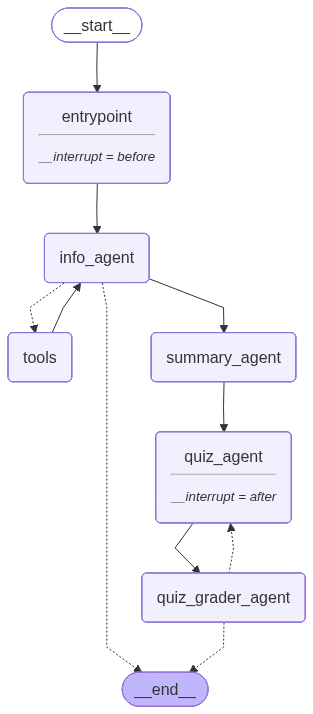

In [21]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [22]:
topic_question = {"topic": "I want to learn about the post treatment care for an ear infection."}
config = {"configurable": {"thread_id": 1}}

In [23]:
for event in graph.stream(input = topic_question, config = config, stream_mode = "values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

In [24]:
state = graph.get_state(config=config)
state

StateSnapshot(values={'messages': [], 'topic': 'I want to learn about the post treatment care for an ear infection.'}, next=('entrypoint',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0dec57-4104-623e-8000-0249f78a3dd6'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-12-21T23:33:28.563142+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0dec57-4101-6e6c-bfff-cb2a5467c2f2'}}, tasks=(PregelTask(id='01fdb79c-a234-2ae4-3bcf-62de302e8cae', name='entrypoint', path=('__pregel_pull', 'entrypoint'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [25]:
state.next

('entrypoint',)

In [26]:
for event in graph.stream(input=None, config = config, stream_mode = "values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

Hi Im the Healthbot Assistant, here to help you understand your diagnoses, your condition,
your treatment options, and your post-treatment care instructions. I can answer any health related
questions you have, and I will quiz you to ensure I achieve my goal to aid you in understanding
how to take proper care of yourself in your post-treatment process..
================================ Human Message =================================

I want to learn about the post treatment care for an ear infection.

Processing if we need search capability.
================================== Ai Message ==================================

Here’s a simple guide to post-treatment care for a typical ear infection (both middle ear and outer ear). If you tell me your age (or your child’s age) and whether it’s “otitis media” (middle ear) or “swimmer’s ear” (outer ear), I can tailor this further.

---

## 1. Medications: How to use them safely

### Ear drops
- **Use exactly as prescribed** (times per day and n

In [27]:
state = graph.get_state(config=config)
state

StateSnapshot(values={'messages': [SystemMessage(content='You are the Healthbot Assistant, here to help patients understand their diagnoses, conditions,treatment options, and provide them post-treatment care instructions. You should only answer health related questions from the patient.', additional_kwargs={}, response_metadata={}, id='7f4269f7-4ac0-4723-9fa0-21253af09841'), AIMessage(content='What health topic or medical condition do you want to learn about?', additional_kwargs={}, response_metadata={}, id='c565e3e1-62df-4b55-8041-234658e81fe1'), HumanMessage(content='I want to learn about the post treatment care for an ear infection.', additional_kwargs={}, response_metadata={}, id='280981d1-3a99-4f9f-b4f5-c7343675fbf9'), AIMessage(content='Here’s a simple guide to post-treatment care for a typical ear infection (both middle ear and outer ear). If you tell me your age (or your child’s age) and whether it’s “otitis media” (middle ear) or “swimmer’s ear” (outer ear), I can tailor this 

In [28]:
state.next

('quiz_grader_agent',)

In [29]:
patient_answer = {"patient_answer": "b"}
config = {"configurable": {"thread_id": 1}}

In [30]:
for event in graph.stream(input=patient_answer, config = config, stream_mode = "values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

Which of the following is true about managing this ear infection?

A) Stop ear drops as soon as you feel better.
B) Keep the ear dry and avoid swimming until your clinician says it's safe.
C) You can insert objects into the ear to relieve pressure.
D) Do not use any ear protection during baths or showers.


In [31]:
state = graph.get_state(config=config)

In [32]:
state.next

('entrypoint',)

In [33]:
for event in graph.stream(input=None, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

Which of the following is true about managing this ear infection?

A) Stop ear drops as soon as you feel better.
B) Keep the ear dry and avoid swimming until your clinician says it's safe.
C) You can insert objects into the ear to relieve pressure.
D) Do not use any ear protection during baths or showers.
Hi Im the Healthbot Assistant, here to help you understand your diagnoses, your condition,
your treatment options, and your post-treatment care instructions. I can answer any health related
questions you have, and I will quiz you to ensure I achieve my goal to aid you in understanding
how to take proper care of yourself in your post-treatment process..
================================ Human Message =================================

I want to learn about the post treatment care for an ear infection.

Processing if we need search capability.
================================== Ai Message ==================

In [34]:
state = graph.get_state(config=config)

In [35]:
state.next

('quiz_grader_agent',)

In [36]:
state

StateSnapshot(values={'messages': [SystemMessage(content='You are the Healthbot Assistant, here to help patients understand their diagnoses, conditions,treatment options, and provide them post-treatment care instructions. You should only answer health related questions from the patient.', additional_kwargs={}, response_metadata={}, id='7f4269f7-4ac0-4723-9fa0-21253af09841'), AIMessage(content='What health topic or medical condition do you want to learn about?', additional_kwargs={}, response_metadata={}, id='c565e3e1-62df-4b55-8041-234658e81fe1'), HumanMessage(content='I want to learn about the post treatment care for an ear infection.', additional_kwargs={}, response_metadata={}, id='280981d1-3a99-4f9f-b4f5-c7343675fbf9'), AIMessage(content='Here’s a simple guide to post-treatment care for a typical ear infection (both middle ear and outer ear). If you tell me your age (or your child’s age) and whether it’s “otitis media” (middle ear) or “swimmer’s ear” (outer ear), I can tailor this 

In [ ]:
def human_in_loop_ask_topic(graph: CompiledStateGraph, topic:str, patient_answer:str, thread_id:int):
    topic = {"topic": topic}
    #config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=topic, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()

    human_input = input("Do you approve the tool calling(Y or N)?: ")
        
    if human_input.lower() == "yes":
        for event in graph.stream(input=None, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
    else:
        AIMessage("Please provide a topic that you want to learn about.").pretty_print()


In [ ]:
def human_in_the_loop_revision(graph: CompiledStateGraph, topic: str, thread_id: int):
    topic = {"topic": topic}
    config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=None, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()
    
    topic = input(state["messages"][-1] + ":")

    if human_input.lower() == "no":
        human_input = input("So what question would you like to ask instead?: ")
        human_message = HumanMessage(content=human_input)
        system_message = SystemMessage("workflow edited by human")
        system_message.pretty_print()
        graph.update_state(
            config=config,
            values={
                "messages":[
                    system_message,
                    human_message,
                ]
            },
        )
        print("updated state, about to print the events in this graph.")
        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
            
    else:
        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()